# Extractive Text Summarization

Open in [Google Colab](https://colab.research.google.com/github/febse/ta2025/blob/main/02-04-Extractive-Summarization.ipynb)
    

- Split the document into sentences (sentence tokenization)
- Assign a score to each sentence
- Pick the top N sentences based on the scores

- Score = Average (non-zero TF-IDF of words in the sentence) 
    - Unimportant words have smaller values in the TF-IDF matrix
    - Important words appearing more often in the sentence will have an even higher score.
    - Average instead of just summing to avoid bias towards longer sentences. 
    - Non-zero elements because the TF-IDF is very sparse and don't want to choose based on variety of words

- TextRank score


In [44]:
import pandas as pd
import numpy as np
import textwrap
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt

In [45]:
nltk.download("punkt")
nltk.download('punkt_tab')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /home/amarov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/amarov/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/amarov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [46]:
df = pd.read_csv("https://github.com/febse/data/raw/refs/heads/main/ta/BBC%20News%20Train.csv.zip")
df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [63]:
doc = df.iloc[90]

print(textwrap.fill(doc["Text"], replace_whitespace=False, fix_sentence_endings=True))

could rivalry overshadow election  tony blair and gordon brown are
desperately trying to stuff the genie of their rivalry back into the
bottle.  along with any number of senior cabinet colleagues  they are
insisting their only job is to win the next election and govern in the
best interests of britain.  it is a message they are aiming directly
at their backbenchers who are becoming irritated and even unnerved by
the continuing claims and counter claims surrounding this alleged
rift.  ian gibson  for example  urged the two men to stop squabbling
declaring:  for goodness sake  sometimes you have to rise above
petulance and make sure that you do your job as effectively as you
can.  those with slim majorities are particularly fearful that the
rift could hit their own hopes of re-election.  tony blair will seek
to reassure labour mps on monday evening at their first meeting of the
new year at westminster - a behind-closed doors meeting which gordon
brown is thought likely to also attend to 

In [18]:
type(doc["Text"])

str

In [48]:
from nltk.tokenize import sent_tokenize

sents = sent_tokenize(doc["Text"])
sents

['campbell to be lions consultant former government communications chief alastair campbell will act as a media consultant to sir clive woodward s 2005 lions on their tour to new zealand.',
 'campbell  who left downing street earlier this year  will advise on media strategy before and during the tour.',
 'i hope i can contribute to the planning and preparation  and to ensuring the media and public get the most out of the tour itself   he said.',
 'i am also looking forward to going out for the later stages of the tour.',
 'woodward s decision to call in prime minister tony blair s former spin doctor springs from the deterioration in media relations on the last lions tour of australia in 2001  when new zealander graham henry was the head coach.',
 'the furore surrounding the newspaper diaries of matt dawson and austin healey was compounded by other disillusioned players venting their frustration through the media.',
 'the lions is a massive media event   said woodward  who will be the he

In [49]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))

X = vectorizer.fit_transform(sents)
tmp = pd.DataFrame(X.toarray())

In [29]:
X.shape

(13, 114)

In [15]:
X = X.toarray()
scores = np.array([np.mean(row[row != 0]) for row in X])
print("Row-wise Mean of Non-zero Elements:\n", scores)

Row-wise Mean of Non-zero Elements:
 [0.24924015 0.25482022 0.21658328 0.34347024 0.26179554 0.40054402
 0.23270168 0.25594703 0.4472136  0.31275452 0.24686998]


In [16]:
sort_idx = np.argsort(-scores)

In [17]:
print("Top sentences:\n")

for i in sort_idx[:5]:
  print(f"%.2f: %s" % (scores[i], sents[i]))

Top sentences:

0.45: we have a long journey ahead to fix these issues.
0.40: the company said these actions should  significantly uplift earnings .
0.34: uk coal said it was making  significant progress  in shaking up the business.
0.31: we continue to make progress and great strides have already been made   said mr spindler.
0.26: it had introduced new wage structures  a new daily maintenance regime for machinery at its mines and methods to continue mining in adverse conditions.


## TextRank

TextRank is an unsupervised keyword and sentence extraction algorithm that is inspired by PageRank, the Google page ranking algorithm in the 1990s and 2000s (@mihalcea2004textrank)

Before we can see how to apply TextRank to text summarization, we need to understand how PageRank works.
PageRank is a link analysis algorithm that assigns a numerical weighting to each element of a hyperlinked set of documents, such as the World Wide Web, with the purpose of "measuring" its relative importance within the set.


```{mermaid}
graph TD
    A[Page A] -->|Link| B[Page B]
    A -->|Link| C[Page C]
    B -->|Link| D[Page D]
    C -->|Link| D
    D -->|Link| A
    D -->|Link| E[Page E]
    E -->|Link| B
```


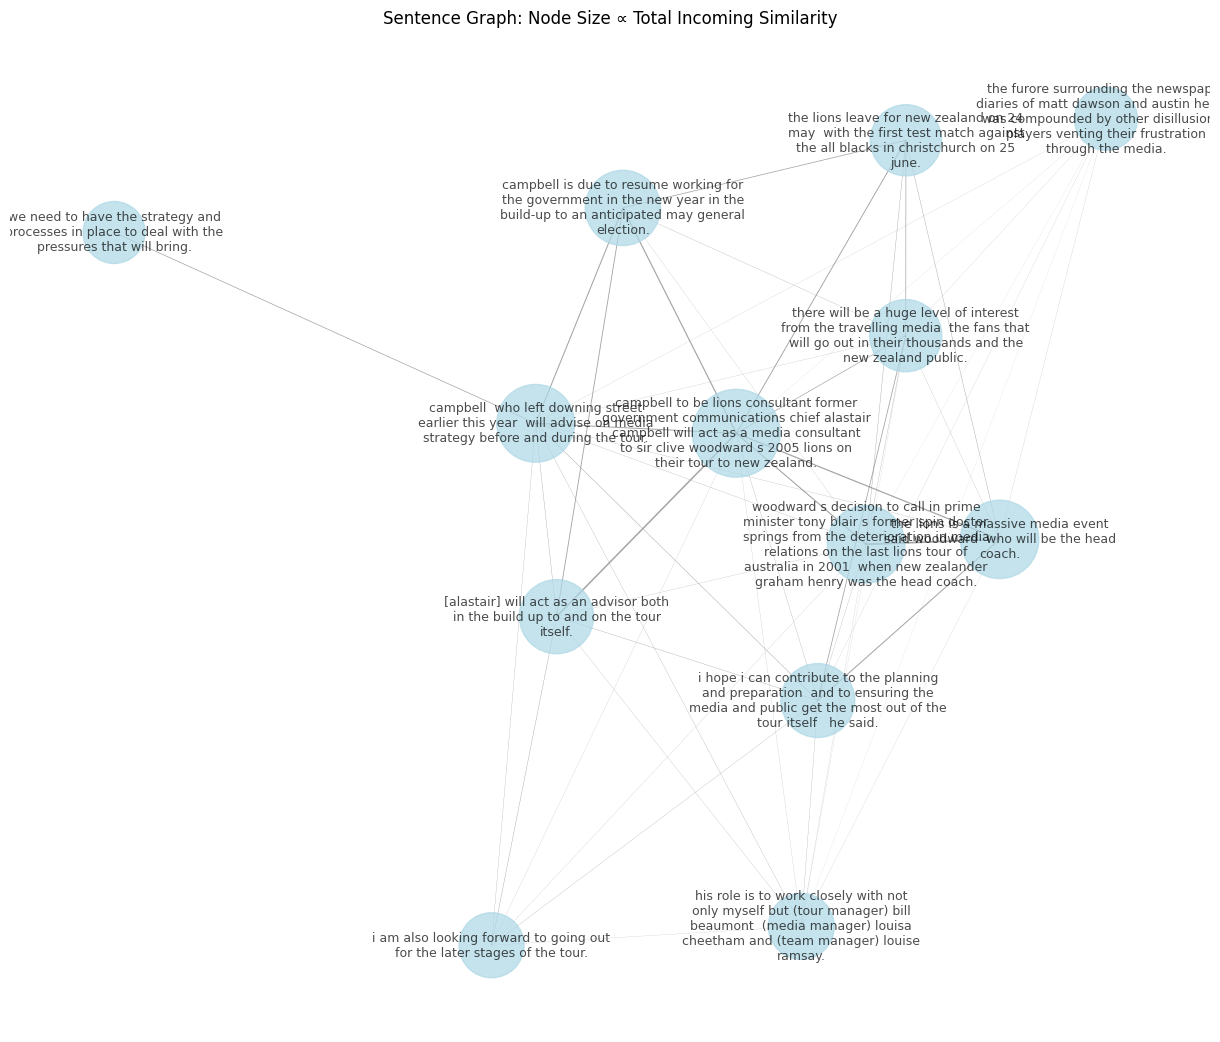

In [33]:
# Wrap sentences for display
wrapped_sents = [textwrap.fill(sent, width=40) for sent in sents]

# Compute cosine similarity matrix (X should be the TF-IDF matrix, already defined)
cos_sim = cosine_similarity(X)

G = nx.Graph()
for i, label in enumerate(wrapped_sents):
    G.add_node(i, label=label)

# Add edges with weights proportional to cosine similarity
for i in range(len(sents)):
    for j in range(i + 1, len(sents)):
        G.add_edge(i, j, weight=cos_sim[i, j])

# Draw the graph with edge width proportional to similarity
pos = nx.spring_layout(G, seed=42)
labels = nx.get_node_attributes(G, 'label')
edges = G.edges(data=True)
weights = [d['weight'] * 5 for (_, _, d) in edges]  # scale for visibility

# Node size proportional to total incoming similarity
node_sim = cos_sim.sum(axis=1)
node_sizes = node_sim * 4000 / node_sim.max()  # increased scale for visibility

plt.figure(figsize=(12, 10))
nx.draw(
    G, pos, with_labels=True, labels=labels,
    node_size=node_sizes, node_color='lightblue', font_size=9,
    font_color='black', alpha=0.7,
    width=weights, edge_color='gray'
)
plt.title("Sentence Graph: Node Size ∝ Total Incoming Similarity")
plt.show()

Let's take a walk through the web. We start at a random webpage and follow a random link on that page. On the next page, we again follow a randomly chosen link. We keep doing this for a long time. We can ask a question: what is the probability that we end up on a certain page?

We can view this walk as a Markov chain. Say that all pages are $n$ and let's assume that we can reach any page from any other page (though not 
with the same probability).

In [234]:
# print()

In [18]:
import nltk
from nltk.corpus import gutenberg

nltk.download('gutenberg')


[nltk_data] Downloading package gutenberg to /home/amarov/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [19]:

alice = gutenberg.raw(fileids="carroll-alice.txt")

print(f"Text length: {len(alice)} characters")

# Remove non-word characters and spaces, lowercase

import re
alice_clean = re.sub(r'\s+', '', re.sub(r'[^\w\s]', '', alice)).lower()

print(f"Cleaned text length: {len(alice_clean)} characters")

# Convert to a sequence of consonants and vowels

alice_cv = re.sub(r'[aeiou]', 'V', re.sub(r'[^aeiou\s]', 'C', alice_clean))
alice_cv[:100]

Text length: 144395 characters
Cleaned text length: 107693 characters


'VCVCVCVCCVCCVCVCVCCVCCVCCVCCCCCVCVCCVCCVCCCCCCCCVCCVCVCVCCCCVCVCCVCCVCVVCVCVCVCCVCVCCVCCCVCVCCVCCCVC'

In [21]:
# Count the frequencies of vowels and consonants

from collections import Counter
cv_counts = Counter(alice_cv)
cv_counts

Counter({'C': 66212, 'V': 41481})

In [22]:
P_V = cv_counts['V'] / (cv_counts['V'] + cv_counts['C'])  # P(V)
P_C = cv_counts['C'] / (cv_counts['V'] + cv_counts['C'])  # P(C)

print(f"P(V): {P_V:.4f}, P(C): {P_C:.4f}")
# Count the frequencies of VV, CC, VC, CV

P(V): 0.3852, P(C): 0.6148


In [23]:
# Count the frequencies of VV, CC, VC, CV

cv_bigrams = [alice_cv[i:i+2] for i in range(len(alice_cv)-1)]
bigram_counts = Counter(cv_bigrams)
bigram_counts

Counter({'VC': 34838, 'CV': 34837, 'CC': 31374, 'VV': 6643})

In [25]:
V_to_C = 34838 / (34838 + 6643)  # P(V->C | V)
V_to_V = 6643 / (34838 + 6643)   # P(V->C | V)

C_to_C = 31374 / (31374 + 34837) # P(C->C | C)
C_to_V = 34837 / (31374 + 34837) # P(C->V | C)

print(f"P(V->V|V): {V_to_V:.2}, P(V->C|V): {V_to_C:.2}")
print(f"P(C->C|C): {C_to_C:.2}, P(C->V|C): {C_to_V:.2}")

P(V->V|V): 0.16, P(V->C|V): 0.84
P(C->C|C): 0.47, P(C->V|C): 0.53


In [241]:
# Count the frequencies of vowels and consonants

Let's now track the states of the Markov chain as we jump between vowels and consonants in "Alice's Adventures in Wonderland".

We perform a series of transitions between two states: Vowel (V) and Consonant (C). Let's denote the state we are in at step $t$ as $S_t$.
So $S_t = V$ means that at step $t$ we are at a vowel, and $S_t = C$ means we are at a consonant.

- We start by picking a state at random, say with equal probability:
  - $P(S_0 = V) = 0.5$
  - $P(S_0 = C) = 0.5$
- Next, we jump to the next state based on the transition probabilities:
  - $P(S_{t+1} = V | S_t = V) = 0.84$ (probability of going from vowel to vowel)
  - $P(S_{t+1} = C | S_t = V) = 0.16$ (probability of going from vowel to consonant)
  - $P(S_{t+1} = C | S_t = C) = 0.47$ (probability of going from consonant to consonant)
  - $P(S_{t+1} = V | S_t = C) = 0.53$ (probability of going from consonant to vowel)
  

What are the probabilities of landing at a vowel/consonant in step 1? We can use the law of total probability:

$$
\begin{align*}
P(S_1 = v) & = P(S_1 = v | S_0 = v) P(S_0 = v) + P(S_1 = v | S_0 = c) P(S_0 = c) \\
P(S_1 = c) & = P(S_1 = c | S_0 = v) P(S_0 = v) + P(S_1 = c | S_0 = c) P(S_0 = c)
\end{align*}
$$

For the following it will be convenient to express the probabilities as a vector and the transition probabilities as a matrix:

$$
\mathbf{p_t} = \begin{pmatrix} P(S_t = v) & P(S_t = c) \end{pmatrix} , \quad \mathbf{T} = \begin{pmatrix} P(S_{t+1} = v | S_t = v) & P(S_{t+1} = c | S_t = v) \\ P(S_{t+1} = v | S_t = c) & P(S_{t+1} = c | S_t = c) \end{pmatrix}
$$

Now we can express the probabilities for the two states at step $t+1$ as:

$$
\mathbf{p_{t+1}} = \mathbf{p_t} \mathbf{T}
$$

We can recursively apply this to get the probabilities at step $t$ starting from the initial probabilities $\mathbf{p_0}$:

$$
\begin{align*}
\mathbf{p_t} & = \mathbf{p_{t - 1}} \mathbf{T} \mathbf{T} \\
& = \mathbf{p_{t - 2}} \mathbf{T} \mathbf{T} \mathbf{T} \\
& \ \, \vdots \\
              & = \mathbf{p_0} \mathbf{T}^t
\end{align*}
$$

But is there a steady state distribution $\mathbf{p^*}$ such that:

$$
\mathbf{p^*} = \mathbf{p^*} \mathbf{T}
$$

The answer is provided by the Perron-Frobenius theorem, which states that an ergodic Markov chain has a unique stationary distribution. To be ergodic, the Markov chain must be irreducible (it is possible to get to any state from any state) and aperiodic (the system does not get trapped in cycles).

How do we compute $\mathbf{p^*}$?

The last equation can be rewritten as:

$$
\mathbf{p^*} (\mathbf{T} - \mathbf{I}) = 0
$$

which is an eigenvalue problem. The stationary distribution $\mathbf{p^*}$ is the left eigenvector of the transition matrix $\mathbf{T}$ corresponding to the eigenvalue 1.



In [29]:
import numpy as np

p0 = np.array([0.02, 1 - 0.02])

T = np.array([[V_to_V, V_to_C],
              [C_to_V, C_to_C]])

print("Transition Matrix:\n", T)

def markov_step(p, T):
    return np.dot(p, T)

for step in range(10):
    p0 = markov_step(p0, T)
    print(f"After step {step+1}: P(V)={p0[0]:.4f}, P(C)={p0[1]:.4f}")

Transition Matrix:
 [[0.16014561 0.83985439]
 [0.52615124 0.47384876]]
After step 1: P(V)=0.5188, P(C)=0.4812
After step 2: P(V)=0.3363, P(C)=0.6637
After step 3: P(V)=0.4031, P(C)=0.5969
After step 4: P(V)=0.3786, P(C)=0.6214
After step 5: P(V)=0.3876, P(C)=0.6124
After step 6: P(V)=0.3843, P(C)=0.6157
After step 7: P(V)=0.3855, P(C)=0.6145
After step 8: P(V)=0.3851, P(C)=0.6149
After step 9: P(V)=0.3852, P(C)=0.6148
After step 10: P(V)=0.3852, P(C)=0.6148


In [30]:
# Compute the steady-state distribution
eigenvalues, eigenvectors = np.linalg.eig(T.T)

print("Eigenvalues:", eigenvalues)
print("Eigenvectors:\n", eigenvectors)

# Find the eigenvector corresponding to eigenvalue 1
eigenvector_to_ev_1 = eigenvectors[:, 1]

# Normalize to get probabilities
stationary_dist = eigenvector_to_ev_1 / eigenvector_to_ev_1.sum()

print(f"\nStationary distribution: {stationary_dist}")
print(f"P(V) = {stationary_dist[0]:.4f}, P(C) = {stationary_dist[1]:.4f}")

Eigenvalues: [-0.36600563  1.        ]
Eigenvectors:
 [[-0.70710678 -0.53090001]
 [ 0.70710678 -0.84743447]]

Stationary distribution: [0.38517502 0.61482498]
P(V) = 0.3852, P(C) = 0.6148


:::{.callout-note}
## Numpy and Eigenvalues

You may have noticed that we called `np.linalg.eig` with the transpose of the transition matrix.
This is because `np.linalg.eig` computes the right eigenvectors of a matrix, i.e., it solves the equation:

$$
\mathbf{A} \mathbf{v} = \lambda \mathbf{v}
$$

where $\mathbf{v}$ is a column vector. Your $\mathbf{p}_t$ vector is a row vector, so to find
the correct eigenvector we need to transpose the matrix:

$$
\mathbf{v}^T \mathbf{A} = \lambda \mathbf{v}^T
$$

:::



The TextRank algorithm scores sentences based on the stationary distribution of a Markov chain. Instead of webpages we have sentences. There are no real transition probabilities between sentences, but we can use the cosine similarity between the sentence representations in the TF-IDF space as a proxy.

Let's implement it as an exercise.

- Compute the TF-IDF matrix of the sentences
- Compute the cosine similarity matrix
- Normalize the cosine similarity matrix to get the transition matrix
- Smooth the transition matrix
- Compute the stationary distribution
- Rank the sentences based on the stationary distribution


In [244]:
# We already have th TF-IDF matrix X from before

print("X shape:", X.shape)
print(X)

X shape: (11, 113)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.27769841 0.         0.        ]
 [0.23406501 0.23406501 0.         ... 0.         0.         0.20007025]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.27019104 ... 0.         0.         0.23094946]]


In [51]:
# Now we compute the cosine similarity matrix
# between each pair of sentences

from sklearn.metrics.pairwise import cosine_similarity

cosine_sim_matrix = cosine_similarity(X)

print("Cosine similarity shape:", cosine_sim_matrix.shape)
print("Cosine Similarity Matrix:\n", cosine_sim_matrix)

Cosine similarity shape: (13, 13)
Cosine Similarity Matrix:
 [[1.         0.14334602 0.04294913 0.02614806 0.16200686 0.01539172
  0.17633605 0.09508995 0.         0.22054086 0.0275078  0.17092539
  0.13466419]
 [0.14334602 1.         0.06667221 0.04059102 0.04097138 0.02389338
  0.03697016 0.02904227 0.10393355 0.05428576 0.04270182 0.15282643
  0.        ]
 [0.04294913 0.06667221 1.         0.03952457 0.03989493 0.02326562
  0.14775674 0.11607178 0.         0.0528595  0.04157991 0.
  0.        ]
 [0.02614806 0.04059102 0.03952457 1.         0.02428862 0.
  0.         0.         0.         0.05968608 0.02531446 0.
  0.        ]
 [0.16200686 0.04097138 0.03989493 0.02428862 1.         0.01429718
  0.25731599 0.04590458 0.         0.0324832  0.02555167 0.0270683
  0.05632765]
 [0.01539172 0.02389338 0.02326562 0.         0.01429718 1.
  0.0279957  0.0219923  0.         0.         0.01490103 0.
  0.        ]
 [0.17633605 0.03697016 0.14775674 0.         0.25731599 0.0279957
  1.         

In [52]:
cosine_sim_matrix.sum(axis=1)

array([2.21490603, 1.73523401, 1.57057438, 1.2155528 , 1.72611034,
       1.14173693, 1.76378349, 1.49951635, 1.10393355, 1.57950947,
       1.25258026, 1.62595491, 1.45665195])

In [53]:
# This matrix is no transition matrix, though 
# as the rows do not sum to 1.

T = cosine_sim_matrix / cosine_sim_matrix.sum(axis=1, keepdims=True)

# Check if the rows sum to one
T.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

The PageRank algorithm applies smoothing to the transition matrix as in practice it is not possible for every page to link to every other page.

The smoothing is done by adding a damping factor $d$ to the transition matrix

$$
P = \alpha T + (1-\alpha) E, \quad \alpha \in [0, 1]
$$

where $T$ is the original transition matrix and $E$ is a matrix with all elements equal to $1/n$. The effect
of the smoothing is to ensure that the Markov chain is ergodic, i.e., it is possible to get to any state from any state.

In [55]:
alpha = 0.1

E = np.ones_like(T) / T.shape[0]
P = alpha * T + (1 - alpha) * E

In [56]:
P.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [57]:
# Now we need to find the stationary distribution of P

evals, evecs = np.linalg.eig(P.T)
print("Eigenvalues:\n", evals)

Eigenvalues:
 [1.         0.0336397  0.04144481 0.04721356 0.09160466 0.08721711
 0.08287336 0.07858474 0.07240613 0.06844927 0.06551014 0.05551498
 0.05704548]


In [60]:
ev_stationary = evecs[:,0]
ev_stationary

array([0.28350085, 0.2790738 , 0.27729895, 0.27599248, 0.27758434,
       0.27619669, 0.277919  , 0.27654719, 0.27630978, 0.27650848,
       0.27605685, 0.27671731, 0.27575285])

In [61]:
stationary_dist = ev_stationary / ev_stationary.sum()
stationary_dist

array([0.07863101, 0.07740314, 0.07691087, 0.07654851, 0.07699002,
       0.07660515, 0.07708284, 0.07670236, 0.07663651, 0.07669162,
       0.07656636, 0.07674955, 0.07648205])

In [62]:
# Rank sentences by their stationary distribution probability (TextRank)
ranked_indices = np.argsort(-stationary_dist)
print("Sentences ranked by TextRank probability:\n")
for idx in ranked_indices:
    print(f"{stationary_dist[idx]:.4f}: {sents[idx]}")

Sentences ranked by TextRank probability:

0.0786: campbell to be lions consultant former government communications chief alastair campbell will act as a media consultant to sir clive woodward s 2005 lions on their tour to new zealand.
0.0774: campbell  who left downing street earlier this year  will advise on media strategy before and during the tour.
0.0771: the lions is a massive media event   said woodward  who will be the head coach.
0.0770: woodward s decision to call in prime minister tony blair s former spin doctor springs from the deterioration in media relations on the last lions tour of australia in 2001  when new zealander graham henry was the head coach.
0.0769: i hope i can contribute to the planning and preparation  and to ensuring the media and public get the most out of the tour itself   he said.
0.0767: campbell is due to resume working for the government in the new year in the build-up to an anticipated may general election.
0.0767: there will be a huge level of inte